<h3>Changes made:</h3>

- Changed the image size from (32, 32, 3) to (121, 113, 3).
- Padded the last 2 channels with zeros.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math
import time

import pickle
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms # to modify the samples


In [5]:
torch.cuda.empty_cache() 

In [6]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:False"

In [39]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda:0" if cuda else "cpu")

img_size = (121, 113, 3)  # Change (121, 113, 3) from (32, 32, 3)

timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

# Specify batch sizes for training and testing
train_batch_size = 16 # from 8
inference_batch_size = 8 # from 4

lr = 5e-5
epochs = 50

seed = 1234

hidden_dims = [hidden_dim for _ in range(n_layers)]
torch.manual_seed(seed)
np.random.seed(seed)

In [8]:
# Custom Dataset class to handle your gravitational wave noise images

class GravitationalWaveNoiseDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (array-like): Array or list of images.
            labels (array-like): Array or list of labels corresponding to each image.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        
        # Apply transformations, if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [9]:
# Load the dataset from the pickle file
pickle_file = r'C:\Users\edpaul\Downloads\1000_Grayscale_noise_ps_20241003.pkl'
with open(pickle_file, 'rb') as f:
    noise_images = pickle.load(f)

# Labels for noise images (all labeled as 0 for now)
noise_labels = [0] * len(noise_images)

In [10]:
len(noise_labels)

1000

In [11]:
start_time_0 = time.time()

#transform = ToTensor()

transform = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # Add other transforms as needed
])

data = noise_images
labels = noise_labels

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create Dataset objects
train_dataset = GravitationalWaveNoiseDataset(train_data, train_labels, transform=transform)
test_dataset = GravitationalWaveNoiseDataset(test_data, test_labels, transform=transform)

# Set up the DataLoader for automatic batching and shuffling
kwargs = {'num_workers': 0, 'pin_memory': True}

#train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
#test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False, **kwargs)

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, num_workers = 0, pin_memory = False)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False, num_workers = 0, pin_memory = False)

end_time_0 = time.time()

print(f"Cell time:{end_time_0 - start_time_0:.2f}")


Cell time:0.00


In [12]:
print(len(data), len(train_data), len(test_data))
print(len(train_dataset), len(test_dataset))
print(len(train_loader), len(test_loader))

1000 800 200
800 200
50 25


Label: 0


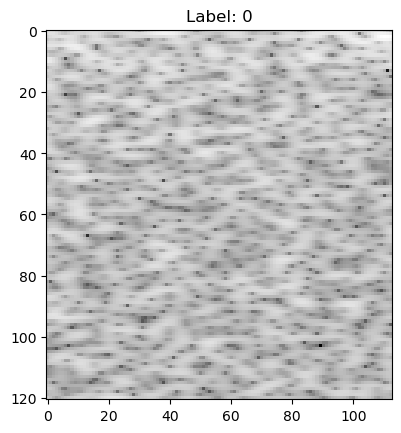

In [13]:
# Index the dataset manually and show the image and label
image, label = train_dataset[0]  # Now returns both image and label
print(f'Label: {label}')  # Should print 0 for noise

# Visualize the image
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f'Label: {label}')
plt.show()

In [14]:
print(type(image), type(label))
print(image.shape)
print(image.squeeze().shape)

<class 'torch.Tensor'> <class 'int'>
torch.Size([1, 121, 113])
torch.Size([121, 113])


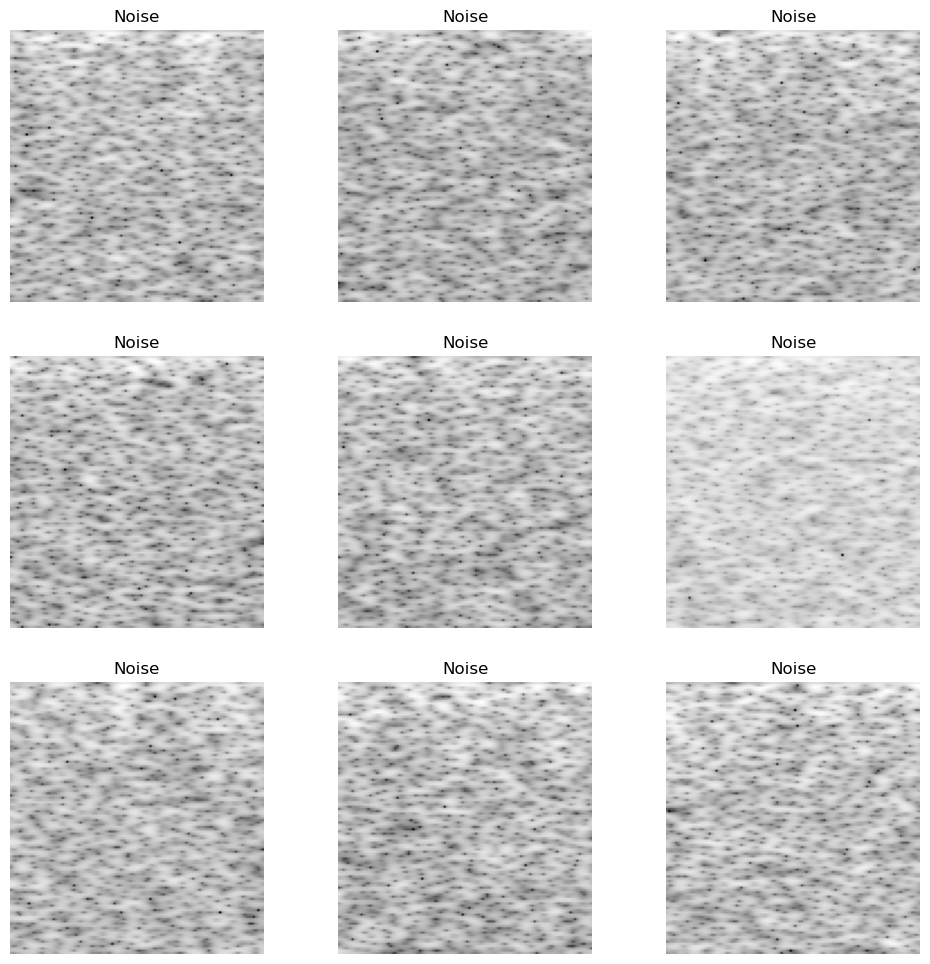

In [15]:
#1
# Use Matplotlib to visualize some samples in the training/test data
labels_map = {
    0: "Noise",
}
figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    #img, label = test_dataset[sample_idx]
    img, label = test_dataset[i]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([16, 1, 121, 113])
Labels batch shape: torch.Size([16])


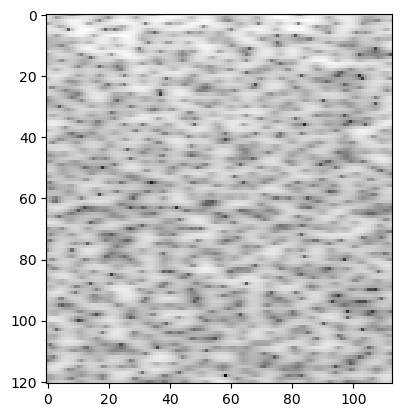

Label: 0
Time to finish: 0.13


In [16]:
start_time_1 = time.time()

# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

end_time_1 = time.time()

print(f"Time to finish: {end_time_1 - start_time_1:.2f}")

Feature batch shape: torch.Size([8, 1, 121, 113])
Labels batch shape: torch.Size([8])


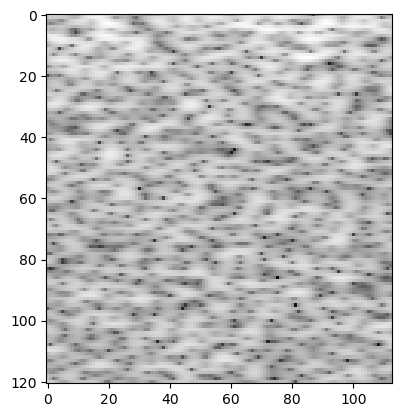

Label: 0
Time to finish: 0.12


In [17]:
start_time_2 = time.time()

# Display image and label.
test_features, test_labels = next(iter(test_loader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[0].squeeze()
label = test_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

end_time_2 = time.time()

print(f"Time to finish: {end_time_2 - start_time_2:.2f}")

<h2>Step 2. Define our model: Denoising Diffusion Probabilistic Models (DDPMs) </h2> <br>
Sinusoidal embedding for diffusion timestep

In [19]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [20]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

<h2> In this tutorial, we use a simple stacked-convolution model with various dilations instead of UNet-like architecture. </h2>

In [22]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        
        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None
        
    def forward(self, x, time_embedding=None, residual=False):
        
        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y
        
        return y

In [23]:
class Denoiser(nn.Module):
    
    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim = 256, n_times=1000):
        super(Denoiser, self).__init__()
        
        _, _, img_C = image_resolution
        
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)
        
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)
        
        self.time_project = nn.Sequential(
                                 ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))
        
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])
        
        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                                    activation_fn=True, gn=True, gn_groups=8))                                
                               
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)
        
        
    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x
        
        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))
        
        y = self.in_project(y)
        
        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual = True)
            
        y = self.out_project(y)
            
        return y
    
model = Denoiser(image_resolution=img_size,
                 hidden_dims=hidden_dims, 
                 diffusion_time_embedding_dim=timestep_embedding_dim, 
                 n_times=n_timesteps).to(DEVICE)

In [24]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):
    
        super(Diffusion, self).__init__()
    
        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution

        self.model = model
        
        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device) # follows DDPM paper
        self.sqrt_betas = torch.sqrt(betas)
                                     
        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)
        
        self.device = device
    
    def extract(self, a, t, x_shape):
        """
            from lucidrains' implementation
                https://github.com/lucidrains/denoising-diffusion-pytorch/blob/beb2f2d8dd9b4f2bd5be4719f37082fe061ee450/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py#L376
        """
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))
    
    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1
    
    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5
    
    def make_noisy(self, x_zeros, t): 
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)
        
        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)
        
        # Let's make noisy sample!: i.e., Forward process with fixed variance schedule
        #      i.e., sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar
    
        return noisy_sample.detach(), epsilon
    
    
    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)
        
        B, _, _, _ = x_zeros.shape
        
        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)
        
        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)
        
        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)
        
        return perturbed_images, epsilon, pred_epsilon
    
    
    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape 
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)
        
        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)
        
        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)
        
        # denoise at time t, utilizing predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z
        
        return x_t_minus_1.clamp(-1., 1)
                
    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)
        
        # autoregressively denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)
        
        # denormalize x_0 into 0 ~ 1 ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)
        
        return x_0
    
    
diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps, 
                      beta_minmax=beta_minmax, device=DEVICE).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of model parameters: ", count_parameters(diffusion))

Number of model parameters:  4900611


In [33]:
x.shape

torch.Size([8, 1, 121, 113])

<h3> Visualizing forward process </h3>

In [31]:

model.eval()
for batch_idx, (x, _) in enumerate(test_loader):
    x = x.to(DEVICE)

    # Create two zero-filled channels with the same shape as x
    zero_padding = torch.zeros(x.size(0), 2, x.size(2), x.size(3)).to(x.device)  # Shape (batch_size, 2, height, width)

    # Concatenate the original input (x) with the zero-filled channels along the channel dimension
    x_padded = torch.cat((x, zero_padding), dim=1)

    torch.cuda.empty_cache()
    # Disable gradient calculation during inference to save memory
    with torch.no_grad():
        perturbed_images, epsilon, pred_epsilon = diffusion(x_padded)  # Perform model forward pass without tracking gradients
    perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    break

In [35]:
def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


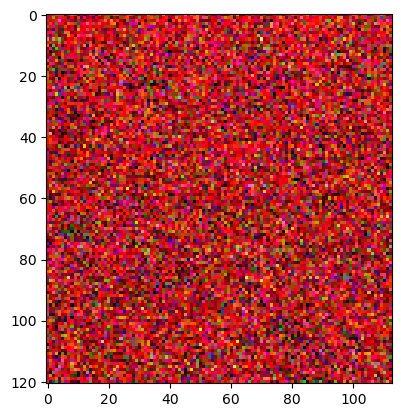

In [37]:
show_image(perturbed_images, idx=1)

<h2> Step 3. Train Denoising Diffusion Probabilistic Models(DDPMs) </h2>

In [43]:

start_time_4 = time.time()

print("Start training DDPMs...")
model.train()

for epoch in range(epochs):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        x = x.to(DEVICE)

        # Expand grayscale image to 3 channels by duplicating it across 3 channels
        # Pad the last 2 channels with zero
        x = x.repeat(1, 3, 1, 1)
        
        noisy_input, epsilon, pred_epsilon = diffusion(x)
        loss = denoising_loss(pred_epsilon, epsilon)
        
        noise_prediction_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / batch_idx)
    
print("Finish!!")

end_time_4 = time.time()

print(f"Total time to finish training: {end_time_4 - start_time_4:.2f} seconds")

Start training DDPMs...


100%|█████████████████████████████████████████████████████████████| 50/50 [07:47<00:00,  9.36s/it]


	Epoch 1 complete! 	Denoising Loss:  0.2727123734598257


100%|█████████████████████████████████████████████████████████████| 50/50 [08:06<00:00,  9.72s/it]


	Epoch 2 complete! 	Denoising Loss:  0.1202002768309749


100%|█████████████████████████████████████████████████████████████| 50/50 [07:51<00:00,  9.44s/it]


	Epoch 3 complete! 	Denoising Loss:  0.09200749645123676


100%|█████████████████████████████████████████████████████████████| 50/50 [07:26<00:00,  8.93s/it]


	Epoch 4 complete! 	Denoising Loss:  0.0784108532326562


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


	Epoch 5 complete! 	Denoising Loss:  0.06237424301857851


100%|█████████████████████████████████████████████████████████████| 50/50 [07:23<00:00,  8.86s/it]


	Epoch 6 complete! 	Denoising Loss:  0.06326291037305277


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


	Epoch 7 complete! 	Denoising Loss:  0.055797674065949966


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.86s/it]


	Epoch 8 complete! 	Denoising Loss:  0.04946724811987001


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


	Epoch 9 complete! 	Denoising Loss:  0.05397944543890807


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


	Epoch 10 complete! 	Denoising Loss:  0.04960457334408955


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.84s/it]


	Epoch 11 complete! 	Denoising Loss:  0.04690019113524836


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.86s/it]


	Epoch 12 complete! 	Denoising Loss:  0.03765762768381713


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


	Epoch 13 complete! 	Denoising Loss:  0.043849906713074566


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


	Epoch 14 complete! 	Denoising Loss:  0.043712375799612124


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.84s/it]


	Epoch 15 complete! 	Denoising Loss:  0.04151672318729819


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


	Epoch 16 complete! 	Denoising Loss:  0.039549666818003266


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.84s/it]


	Epoch 17 complete! 	Denoising Loss:  0.04143574666612002


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


	Epoch 18 complete! 	Denoising Loss:  0.03780294778015541


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.86s/it]


	Epoch 19 complete! 	Denoising Loss:  0.03759939373679915


100%|█████████████████████████████████████████████████████████████| 50/50 [07:21<00:00,  8.84s/it]


	Epoch 20 complete! 	Denoising Loss:  0.03396216662106465


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


	Epoch 21 complete! 	Denoising Loss:  0.029641347481127903


100%|█████████████████████████████████████████████████████████████| 50/50 [07:21<00:00,  8.84s/it]


	Epoch 22 complete! 	Denoising Loss:  0.030723402884845832


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


	Epoch 23 complete! 	Denoising Loss:  0.034791894409121296


100%|█████████████████████████████████████████████████████████████| 50/50 [07:21<00:00,  8.83s/it]


	Epoch 24 complete! 	Denoising Loss:  0.03121203739120036


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


	Epoch 25 complete! 	Denoising Loss:  0.03164942980724938


100%|█████████████████████████████████████████████████████████████| 50/50 [07:21<00:00,  8.83s/it]


	Epoch 26 complete! 	Denoising Loss:  0.0330417113834802


100%|█████████████████████████████████████████████████████████████| 50/50 [07:25<00:00,  8.91s/it]


	Epoch 27 complete! 	Denoising Loss:  0.03103645966977489


100%|█████████████████████████████████████████████████████████████| 50/50 [07:21<00:00,  8.84s/it]


	Epoch 28 complete! 	Denoising Loss:  0.030113030852255772


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.84s/it]


	Epoch 29 complete! 	Denoising Loss:  0.029005321027825073


100%|█████████████████████████████████████████████████████████████| 50/50 [07:21<00:00,  8.84s/it]


	Epoch 30 complete! 	Denoising Loss:  0.029842022787399437


100%|█████████████████████████████████████████████████████████████| 50/50 [07:24<00:00,  8.89s/it]


	Epoch 31 complete! 	Denoising Loss:  0.027137308609576857


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.84s/it]


	Epoch 32 complete! 	Denoising Loss:  0.029428627513044953


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.84s/it]


	Epoch 33 complete! 	Denoising Loss:  0.0308819709497751


100%|█████████████████████████████████████████████████████████████| 50/50 [07:41<00:00,  9.23s/it]


	Epoch 34 complete! 	Denoising Loss:  0.027957836223043958


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


	Epoch 35 complete! 	Denoising Loss:  0.02315949858641442


100%|█████████████████████████████████████████████████████████████| 50/50 [07:23<00:00,  8.87s/it]


	Epoch 36 complete! 	Denoising Loss:  0.0254903911061737


100%|█████████████████████████████████████████████████████████████| 50/50 [07:23<00:00,  8.86s/it]


	Epoch 37 complete! 	Denoising Loss:  0.026276866069101557


100%|█████████████████████████████████████████████████████████████| 50/50 [07:26<00:00,  8.94s/it]


	Epoch 38 complete! 	Denoising Loss:  0.026938977955403377


100%|█████████████████████████████████████████████████████████████| 50/50 [07:30<00:00,  9.01s/it]


	Epoch 39 complete! 	Denoising Loss:  0.027390269562602043


100%|█████████████████████████████████████████████████████████████| 50/50 [07:24<00:00,  8.90s/it]


	Epoch 40 complete! 	Denoising Loss:  0.024231488246242612


100%|█████████████████████████████████████████████████████████████| 50/50 [07:23<00:00,  8.87s/it]


	Epoch 41 complete! 	Denoising Loss:  0.027210135925181057


100%|█████████████████████████████████████████████████████████████| 50/50 [07:31<00:00,  9.03s/it]


	Epoch 42 complete! 	Denoising Loss:  0.025067382986296197


100%|█████████████████████████████████████████████████████████████| 50/50 [08:22<00:00, 10.04s/it]


	Epoch 43 complete! 	Denoising Loss:  0.027164095879665444


100%|█████████████████████████████████████████████████████████████| 50/50 [08:04<00:00,  9.69s/it]


	Epoch 44 complete! 	Denoising Loss:  0.0255083053524853


100%|█████████████████████████████████████████████████████████████| 50/50 [07:37<00:00,  9.16s/it]


	Epoch 45 complete! 	Denoising Loss:  0.02242834350968502


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.84s/it]


	Epoch 46 complete! 	Denoising Loss:  0.02443146034695056


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


	Epoch 47 complete! 	Denoising Loss:  0.025464515315786918


100%|█████████████████████████████████████████████████████████████| 50/50 [07:21<00:00,  8.84s/it]


	Epoch 48 complete! 	Denoising Loss:  0.024530671784008036


100%|█████████████████████████████████████████████████████████████| 50/50 [07:26<00:00,  8.94s/it]


	Epoch 49 complete! 	Denoising Loss:  0.02424764345228976


100%|█████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.86s/it]

	Epoch 50 complete! 	Denoising Loss:  0.025573236734739373
Finish!!
Total time to finish training: 22394.53 seconds


<h2> Step 4. Sample images from noise. </h2>

In [45]:
start_time_3 = time.time()
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)

end_time_3 = time.time()

print(f"Time to finish: {end_time_3 - start_time_3:.2f} seconds")

Time to finish: 120.24 seconds


In [47]:
generated_images.shape

torch.Size([8, 3, 121, 113])

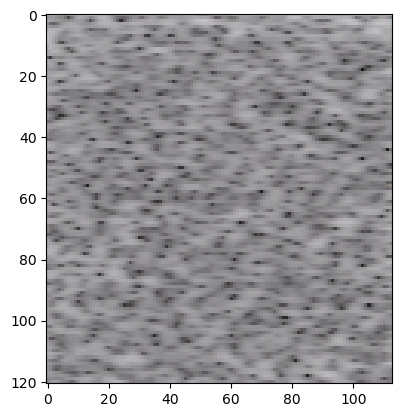

In [49]:
show_image(generated_images, idx=0)

In [51]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0))) # (0, 1, 2)

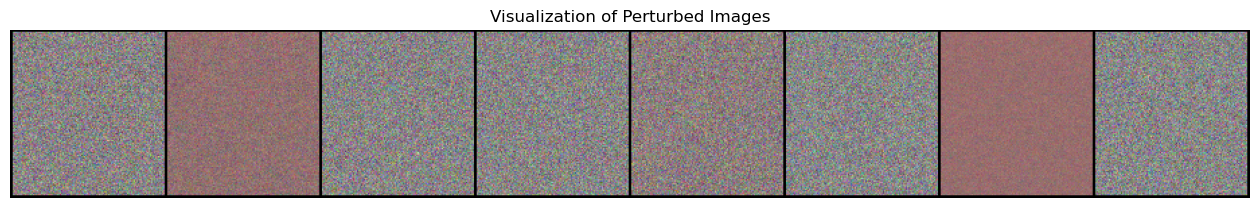

In [53]:
draw_sample_image(perturbed_images, "Perturbed Images")

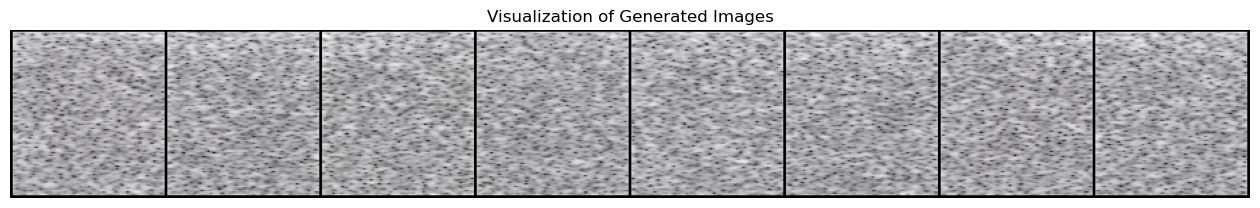

In [55]:
draw_sample_image(generated_images, "Generated Images")

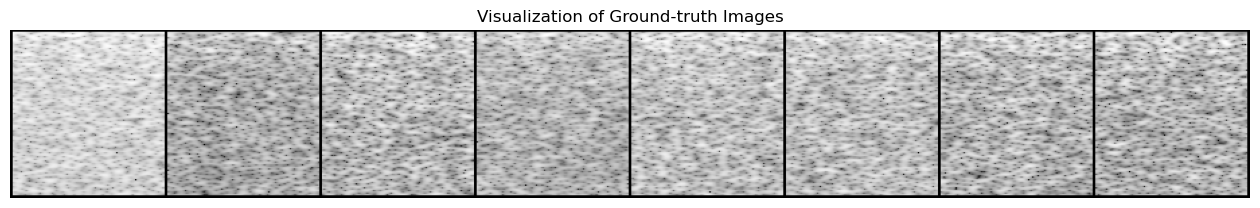

In [57]:
draw_sample_image(x[:inference_batch_size], "Ground-truth Images")